# 연습문제

In [2]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential      # 순서층을 구성하는 모델 객체 생성 기능
from tensorflow.keras.layers import Dense           # 모델 객체에 학습을 위한 층을 쌓는다.
from tensorflow.keras.optimizers import RMSprop,SGD # 옵티마이저
from tensorflow.keras.losses import mse             # 활성화 함수
import pandas as pd 
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import helper


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
# 학습에 대한 콜백함수 참조
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

## #02. 데이터 준비

In [3]:
origin = pd.read_excel('https://data.hossam.kr/F02/fish2.xlsx')
origin.head()

,길이,높이,두께,무게
0,8.4,2.11,1.41,5.9
1,13.7,3.53,2.00,32.0
2,15.0,3.82,2.43,40.0
3,16.2,4.59,2.63,51.5
4,17.4,4.59,2.94,70.0


## #03. 데이터 전처리

In [4]:
origin.isnull().sum()

길이    0
높이    0
두께    0
무게    0
dtype: int64

### 상자그림
정규화 ㄱㄱ해야함

<Axes: >

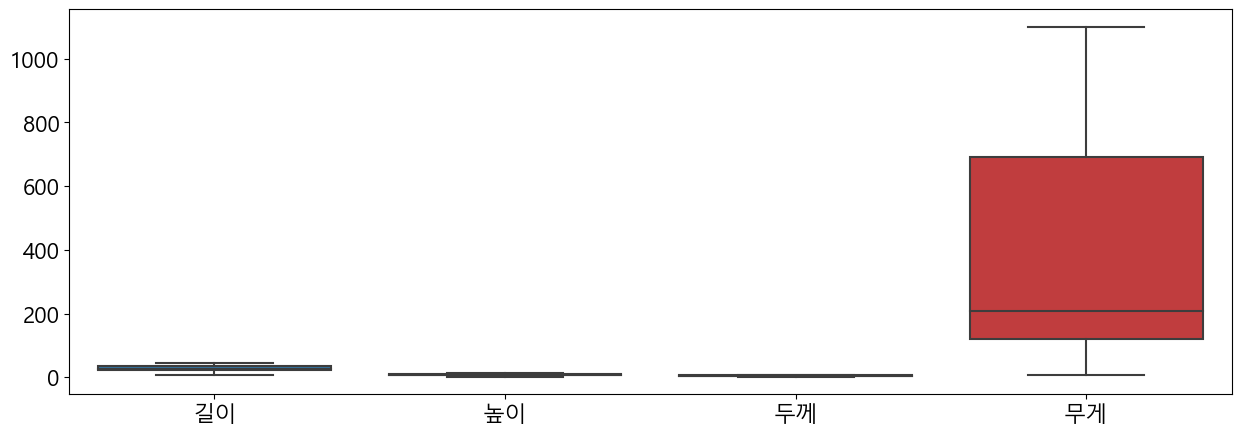

In [5]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(15,5))
sns.boxplot(data=origin)

### 산점도 그래프와 추세선 확인
선형x -> 다항식 생성해야함



C:\Users\hamin\AppData\Roaming\Python\Python39\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 2000x2000 with 0 Axes>

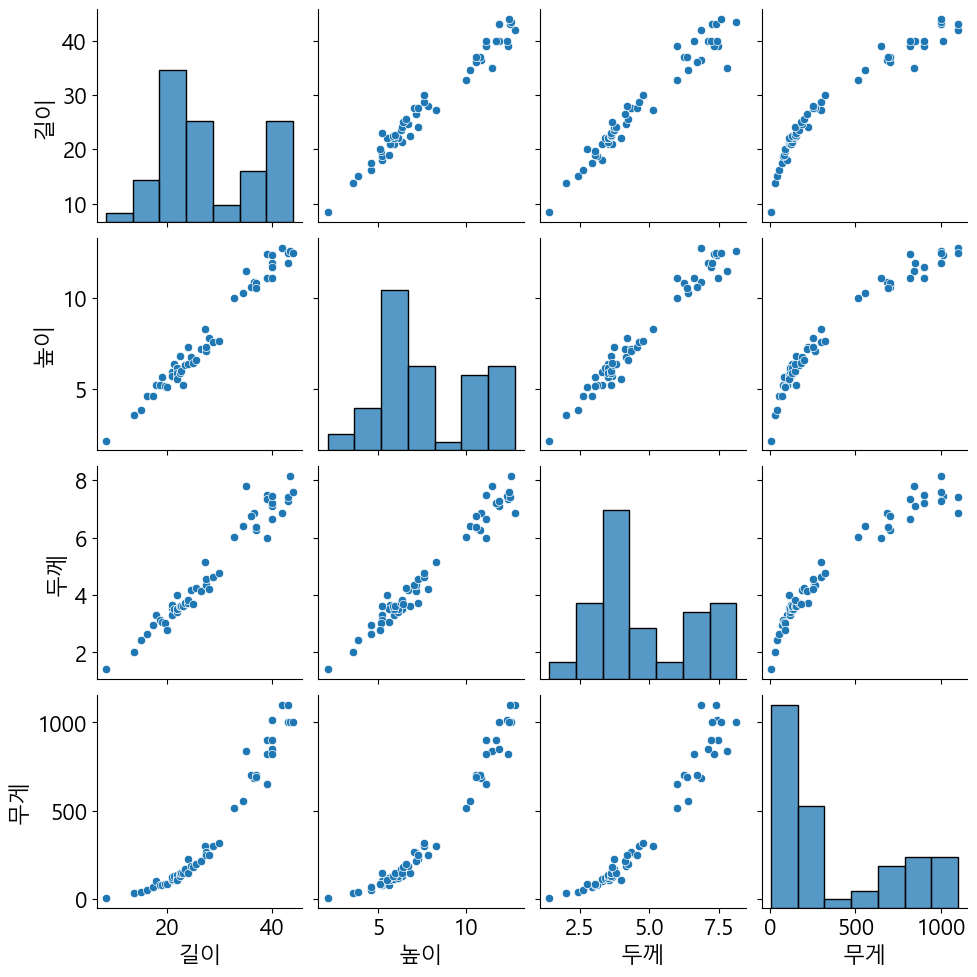

In [6]:


plt.figure(figsize=(20,20))
sns.pairplot(origin)


> 다중공선성이 발생할 것으로 보이고 선형회귀보다는 다항회귀가 적합해 보임(곡선형태기 떄문)

## #04. 다항식 생성

### 독립 - 종속변수 분할

In [9]:
x = origin[['길이','높이','두께']]
y= origin[['무게']]
print('독립변수 : ',x.shape,'종속변수 : ',y.shape)

독립변수 :  (56, 3) 종속변수 :  (56, 1)


### 표준화 하기

In [10]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_scale = x_scaler.fit_transform(x)
y_scale = y_scaler.fit_transform(y)

x_scale.shape,y_scale.shape


((56, 3), (56, 1))

In [11]:
### 표준화 전 후 상자그림 비교 
x_scale_df = pd.DataFrame(x_scale,columns=x.columns)
y_scale_df = pd.DataFrame(y_scale,columns=['무게'])
tmp = pd.merge(x_scale_df,y_scale_df,left_index= True,right_index=True)
tmp.head()

,길이,높이,두께,무게
0,-2.180225,-2.016507,-1.896175,-1.092422
1,-1.587434,-1.518703,-1.560774,-1.016660
2,-1.442032,-1.417039,-1.316328,-0.993438
3,-1.307815,-1.147103,-1.202633,-0.960056
4,-1.173599,-1.147103,-1.026405,-0.906355


In [15]:
poly = PolynomialFeatures(degree=2,include_bias=False)
x_scale_df  = poly.fit_transform(x_scale_df)


In [16]:
poly.get_feature_names_out()

array(['길이', '높이', '두께', '길이^2', '길이 높이', '길이 두께', '높이^2', '높이 두께',
       '두께^2'], dtype=object)

In [17]:
x = pd.DataFrame(x_scale_df,columns=poly.get_feature_names_out())
x.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2
0,-2.180225,-2.016507,-1.896175,4.753381,4.396440,4.134088,4.066302,3.823651,3.595479
1,-1.587434,-1.518703,-1.560774,2.519946,2.410841,2.477625,2.306460,2.370352,2.436014
2,-1.442032,-1.417039,-1.316328,2.079457,2.043416,1.898188,2.008000,1.865289,1.732721
3,-1.307815,-1.147103,-1.202633,1.710381,1.500199,1.572822,1.315845,1.379544,1.446326
4,-1.173599,-1.147103,-1.026405,1.377334,1.346238,1.204588,1.315845,1.177393,1.053508


<Axes: >

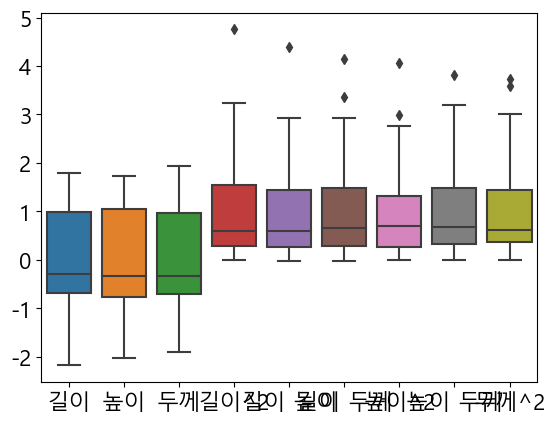

In [18]:
sns.boxplot(x)

## #05. 데이터 분할

### 랜덤시드 고정

In [19]:
np.random.seed(777)

((56, 9), (56, 1))

In [35]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=777)
print(len(y_train),len(x_test))


39 17


<Axes: >

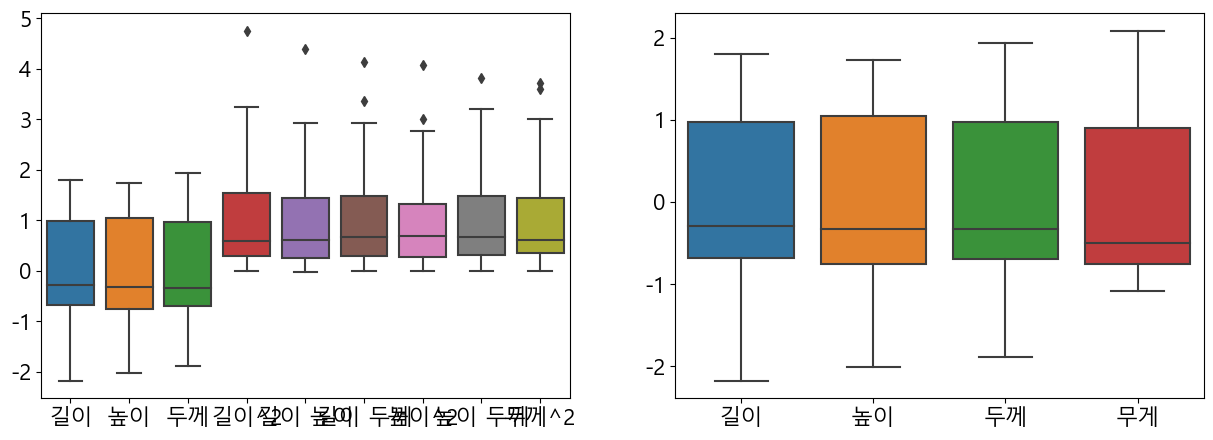

In [36]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=x,ax=ax[0])
sns.boxplot(data=tmp,ax=ax[1])

## #06.모델개발
### 1.모델 정의

In [37]:
len(x.columns)

9

In [38]:
model = Sequential()
model.add(Dense(18,activation = 'relu',input_shape=(9,)))
model.add(Dense(9,activation = 'relu'))
model.add(Dense(1,activation='linear'))

model.compile(optimizer='adam',loss='mse',metrics = ['mae'])
model.summary

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x000002205C67A040>>

### 2. 학습하기

In [39]:
# checkpoint_path = os.path.join("D:\\tensorflow_checkpoint\\model07-cp-{epoch:04d}-chpt")

result= model.fit(x_train,y_train, epochs=500,validation_data = (x_test,y_test),callbacks=[
    EarlyStopping(monitor='val_loss',patience=10,verbose=1),
    ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.5,min_lir=0.0001,verbose=1),
    # ModelCheckpoint(filepath=checkpoint_path,monitor='val_loss',verbose=1,save_best_only=True)
    ])



result_df = pd.DataFrame(result.history)
result_df['epochs'] = result_df.index + 1
result_df.set_index('epochs',inplace=True)
result_df

Epoch 1/500
2/2 [==============================] - 3s 611ms/step - loss: 283431.5625 - mae: 395.6794 - val_loss: 221680.9375 - val_mae: 351.1727 - lr: 0.0010
Epoch 2/500
2/2 [==============================] - 0s 105ms/step - loss: 283372.7188 - mae: 395.6312 - val_loss: 221630.6719 - val_mae: 351.1293 - lr: 0.0010
Epoch 3/500
2/2 [==============================] - 0s 59ms/step - loss: 283315.4375 - mae: 395.5854 - val_loss: 221587.3125 - val_mae: 351.0891 - lr: 0.0010
Epoch 4/500
2/2 [==============================] - 0s 92ms/step - loss: 283261.3750 - mae: 395.5393 - val_loss: 221547.3281 - val_mae: 351.0505 - lr: 0.0010
Epoch 5/500
2/2 [==============================] - 0s 80ms/step - loss: 283204.0000 - mae: 395.4928 - val_loss: 221513.7500 - val_mae: 351.0160 - lr: 0.0010
Epoch 6/500
2/2 [==============================] - 0s 77ms/step - loss: 283157.7500 - mae: 395.4521 - val_loss: 221485.0781 - val_mae: 350.9839 - lr: 0.0010
Epoch 7/500
2/2 [==============================] - 0s 90

,loss,mae,val_loss,val_mae,lr
epochs,,,,,
1,283431.562500,395.679382,221680.937500,351.172699,0.001
2,283372.718750,395.631195,221630.671875,351.129303,0.001
3,283315.437500,395.585358,221587.312500,351.089142,0.001
4,283261.375000,395.539276,221547.328125,351.050537,0.001
5,283204.000000,395.492798,221513.750000,351.016022,0.001
...,...,...,...,...,...
496,26778.439453,129.203583,17232.050781,115.763885,0.001
497,26693.505859,129.004654,17213.843750,115.639343,0.001
498,26613.638672,128.782578,17195.734375,115.501419,0.001


### 7) 학습 결과 평가
#### 1. 학습결과 시각화

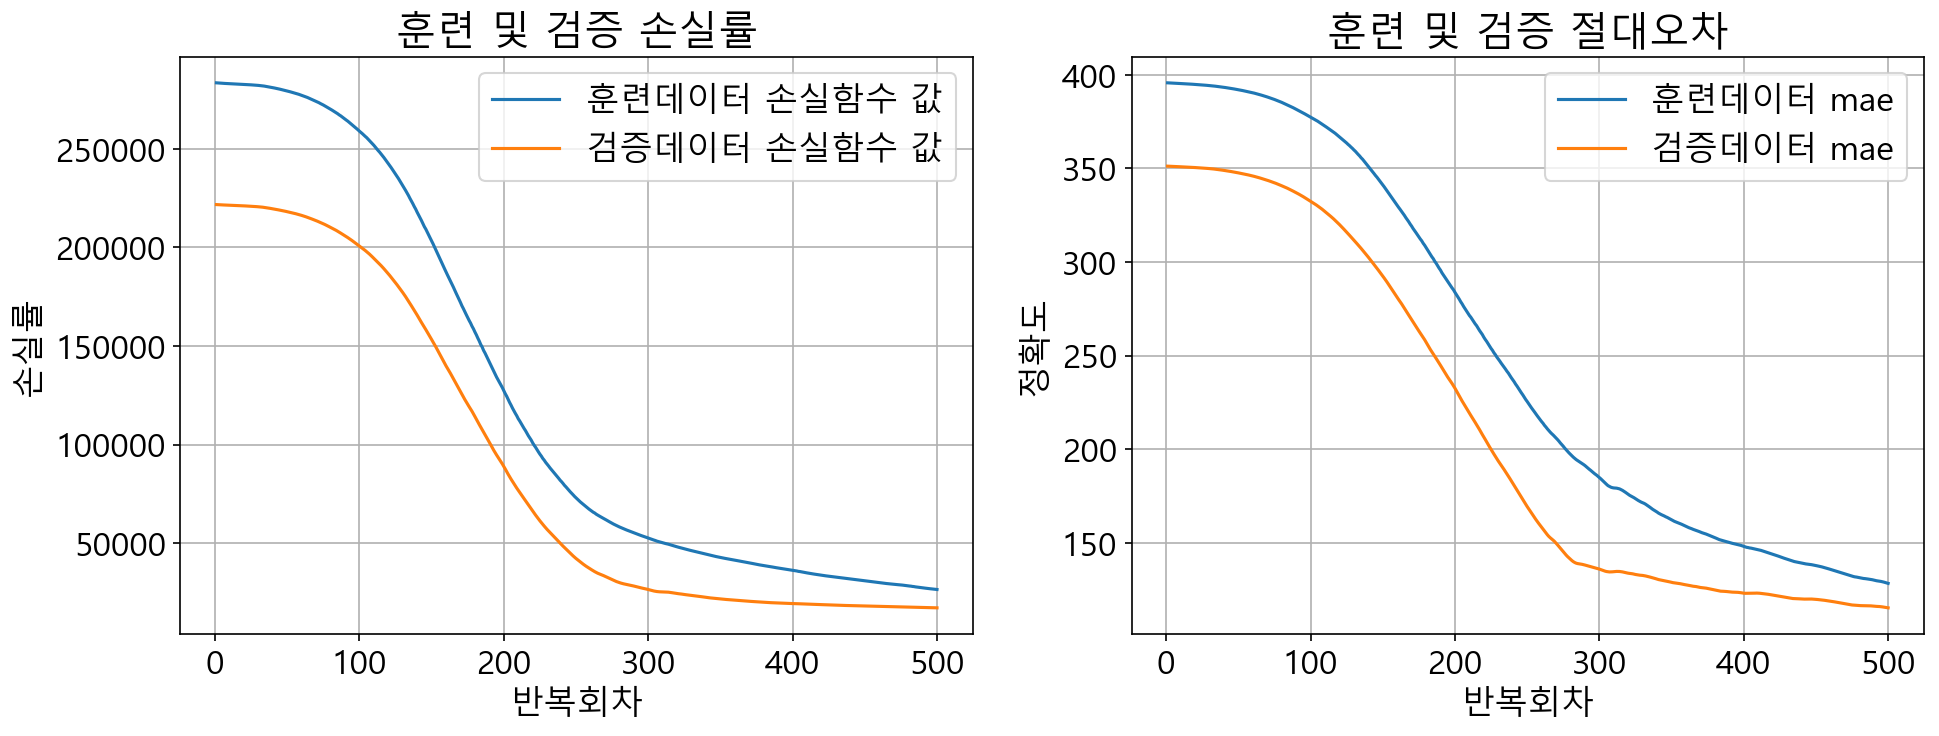

In [40]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# 1) 훈련 및 검증데이터 손실함수 시각화
sns.lineplot(x=result_df.index , y='loss',data = result_df,label = '훈련데이터 손실함수 값',ax=ax1)
sns.lineplot(x=result_df.index , y= 'val_loss',data=result_df,label = '검증데이터 손실함수 값',ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()
# 2) 훈련 및 검증 절대오차 그리기
sns.lineplot(x=result_df.index,y='mae',data=result_df,label='훈련데이터 mae',ax=ax2)
sns.lineplot(x=result_df.index,y='val_mae',data=result_df,label='검증데이터 mae',ax=ax2)

ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

#### 2. 모델 성능 평가

In [41]:
evaluate1 = model.evaluate(x_train,y_train)

evaluate2 = model.evaluate(x_test,y_test)
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate1[0], evaluate1[1]))
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate2[0], evaluate2[1]))



1/1 [==============================] - 0s 49ms/step - loss: 17161.1816 - mae: 115.2591
최종 훈련 손실률: 26392.111328, 최종 훈련 절대오차: 128.177078
최종 훈련 손실률: 17161.181641, 최종 훈련 절대오차: 115.259071


## #08. 학습 결과 적용
### 1. 테스트 데이터에 대한 예측 결과 산정

In [42]:
results = model.predict(x_test)
print(results)

1/1 [==============================] - 0s 131ms/step
[[  42.27381 ]
 [  46.79871 ]
 [  40.38598 ]
 [  61.848484]
 [  98.64311 ]
 [  44.920433]
 [  53.01207 ]
 [ 101.04794 ]
 [  80.271416]
 [ 962.1008  ]
 [  41.89038 ]
 [ 566.81714 ]
 [ 544.1083  ]
 [1227.0645  ]
 [ 161.78622 ]
 [ 596.47394 ]
 [  49.44986 ]]


### 2. 결과 데이터 구성

In [43]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

1/1 [==============================] - 0s 63ms/step


In [44]:
train_df = pd.DataFrame(x_train,columns = x.columns)
train_df['무게(관측치)'] = y_train
train_df['무게(예측치)'] = train_pred

train_df['훈련오차'] = train_df['무게(관측치)'] - train_df['무게(예측치)']

train_df.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게(관측치),무게(예측치),훈련오차
8,-0.927534,-0.954292,-0.969558,0.860320,0.885138,0.899298,0.910672,0.925241,0.940042,85.0,87.241905,-2.241905
0,-2.180225,-2.016507,-1.896175,4.753381,4.396440,4.134088,4.066302,3.823651,3.595479,5.9,599.556763,-593.656763
15,-0.659101,-0.779008,-0.696689,0.434414,0.513445,0.459188,0.606854,0.542726,0.485375,120.0,48.151703,71.848297
26,-0.368297,-0.396891,-0.327179,0.135643,0.146174,0.120499,0.157523,0.129854,0.107046,188.0,34.117508,153.882492
51,1.577847,1.731046,1.207709,2.489601,2.731326,1.905580,2.996521,2.090600,1.458561,1100.0,953.444336,146.555664


In [45]:
test_df = pd.DataFrame(x_test,columns = x.columns)
test_df['무게(관측치)'] = y_test
test_df['무게(예측치)'] = test_pred

test_df['훈련오차'] = test_df['무게(관측치)'] - test_df['무게(예측치)']

test_df.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게(관측치),무게(예측치),훈련오차
16,-0.659101,-0.614242,-0.696689,0.434414,0.404847,0.459188,0.377294,0.427936,0.485375,130.0,42.273811,87.726189
12,-0.770948,-0.761480,-0.611417,0.594361,0.587062,0.471371,0.579852,0.465582,0.373831,125.0,46.798710,78.201290
21,-0.580807,-0.670333,-0.634156,0.337337,0.389334,0.368323,0.449346,0.425096,0.402154,145.0,40.385979,104.614021
33,-0.043940,-0.204080,-0.099788,0.001931,0.008967,0.004385,0.041649,0.020365,0.009958,250.0,61.848484,188.151516
36,0.235678,-0.084887,0.013907,0.055544,-0.020006,0.003278,0.007206,-0.001181,0.000193,320.0,98.643112,221.356888


### 3. 실제 결과값과 머신러닝에 의한 예측값 비교

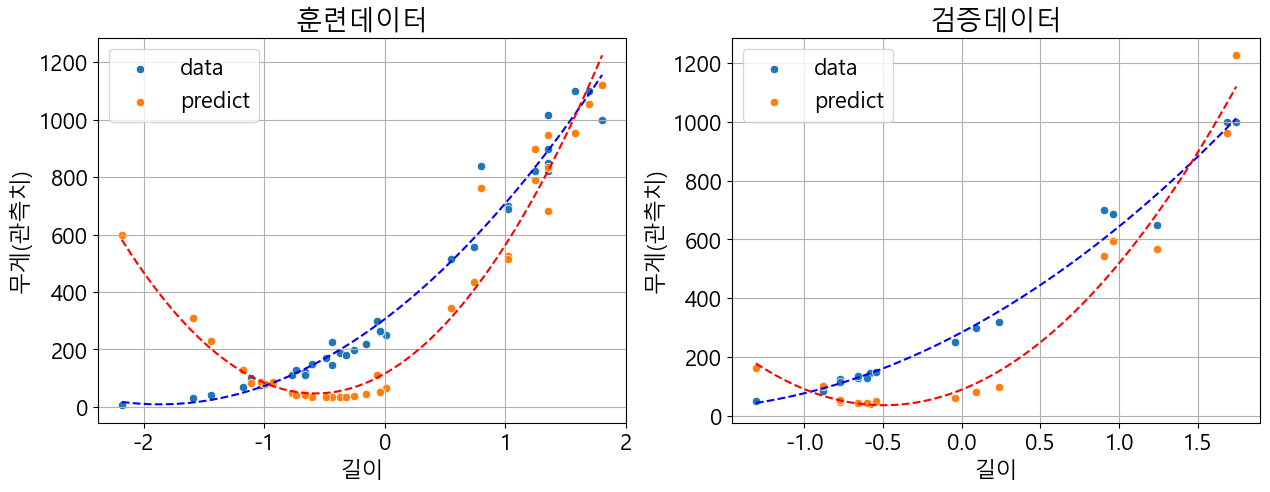

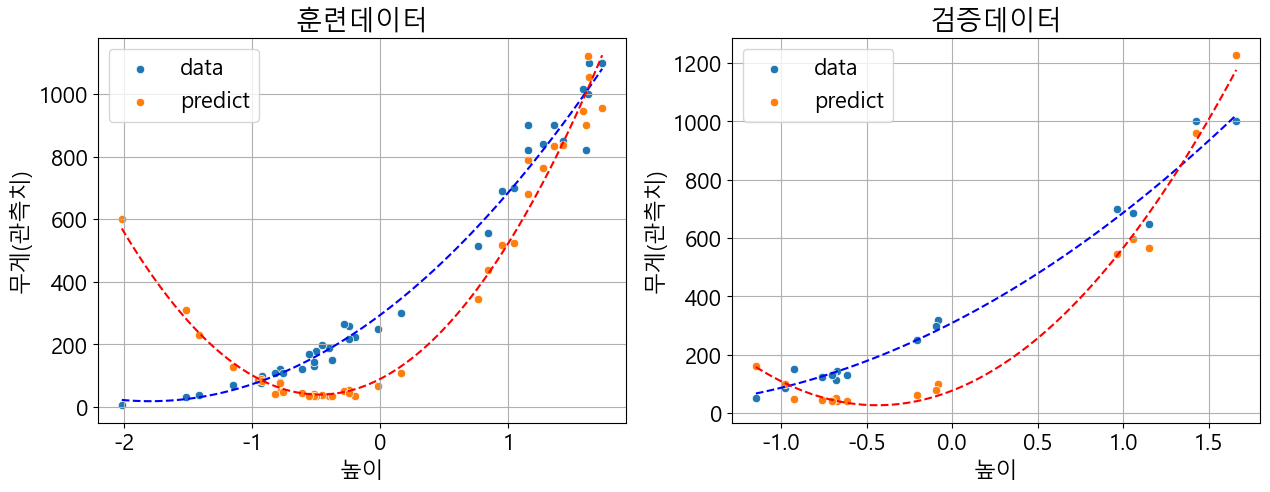

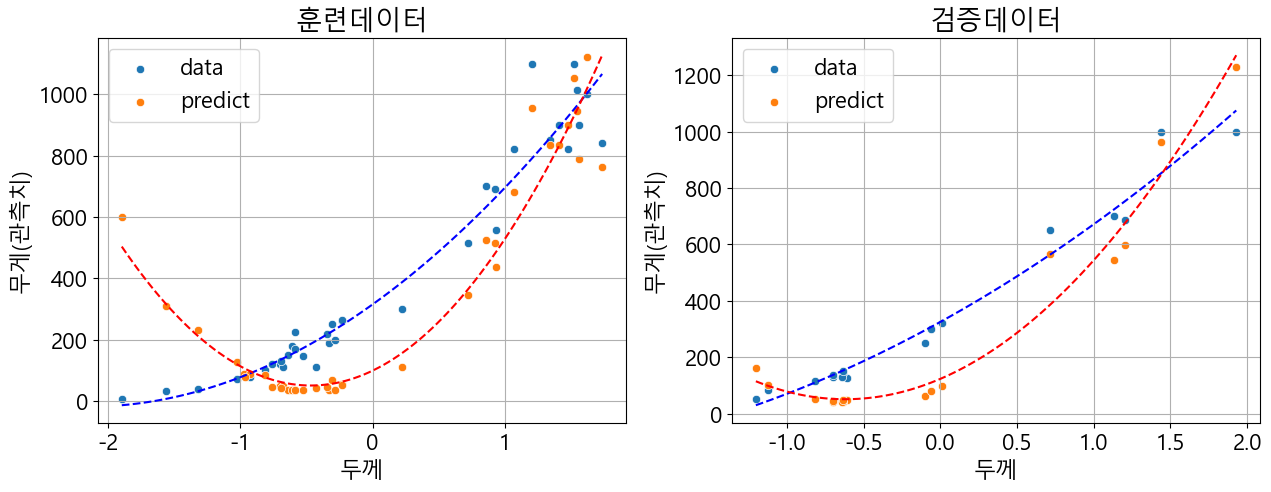

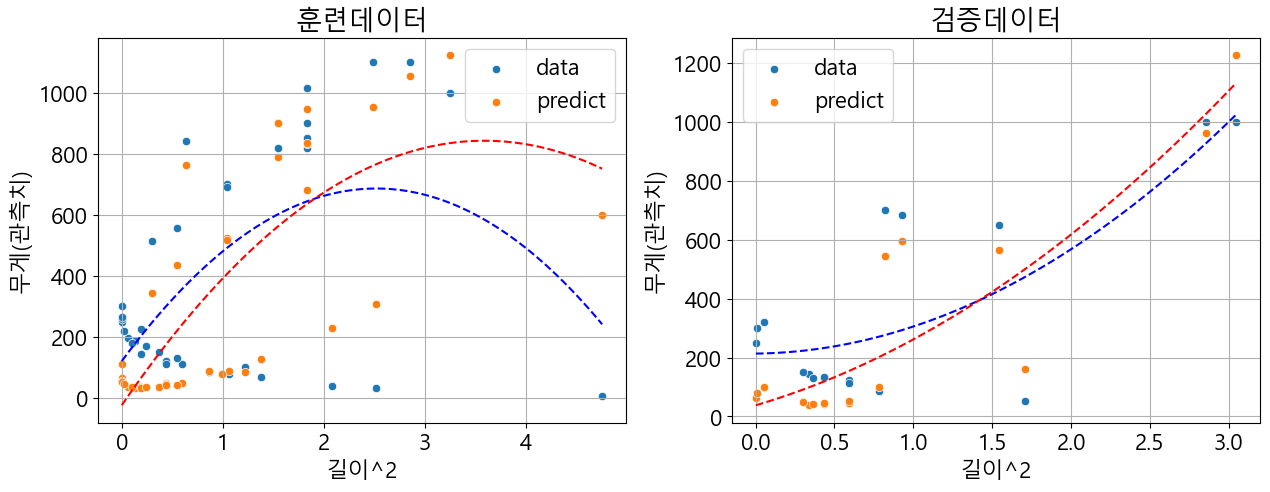

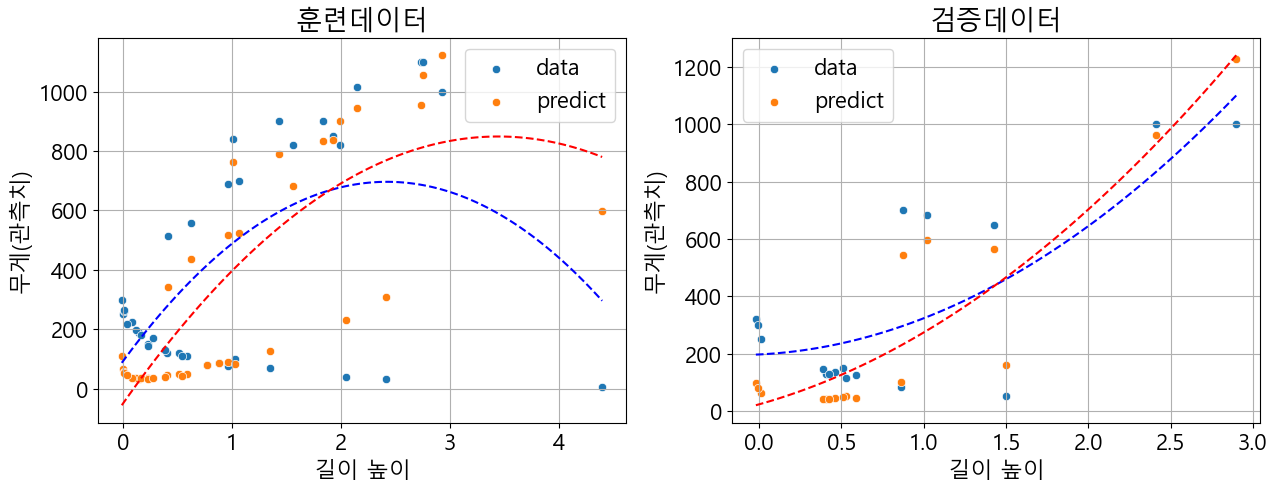

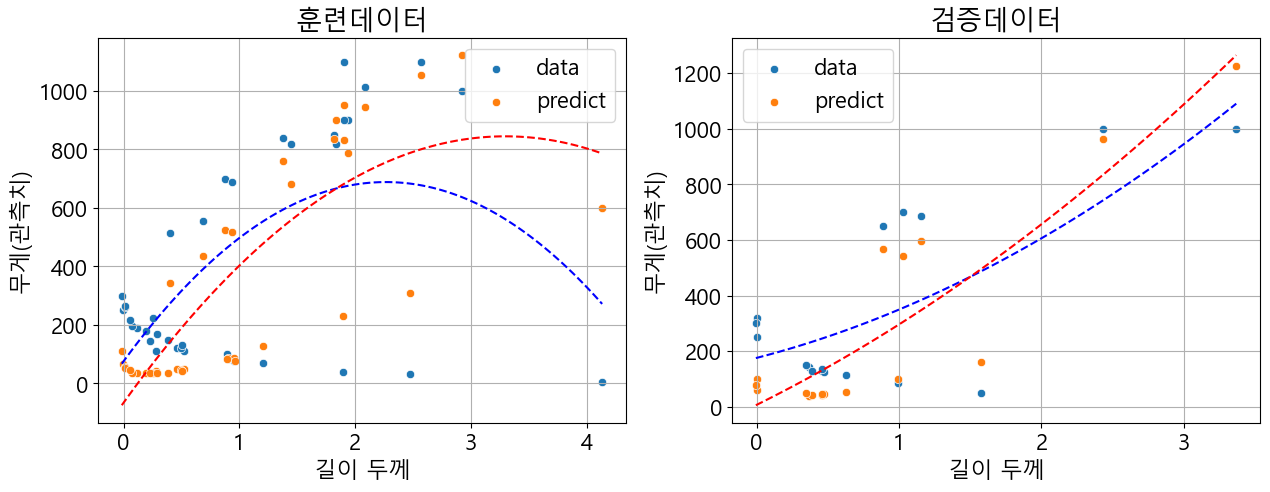

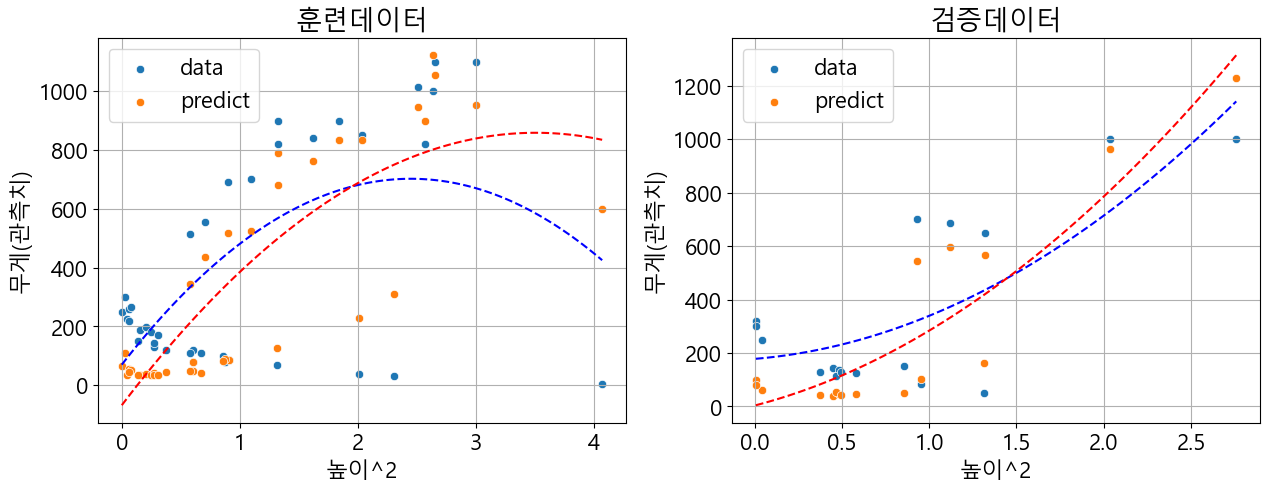

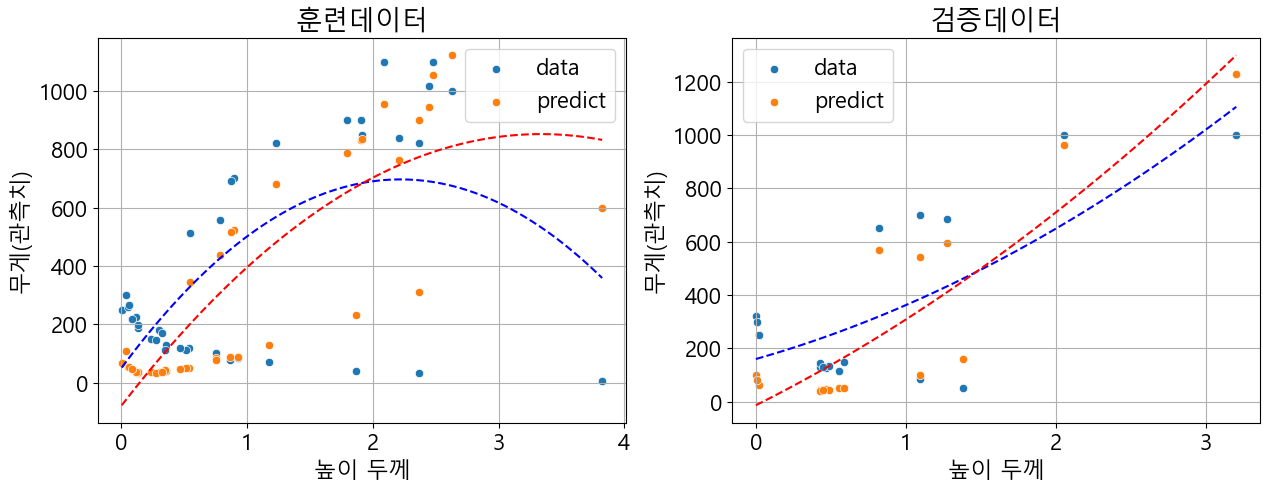

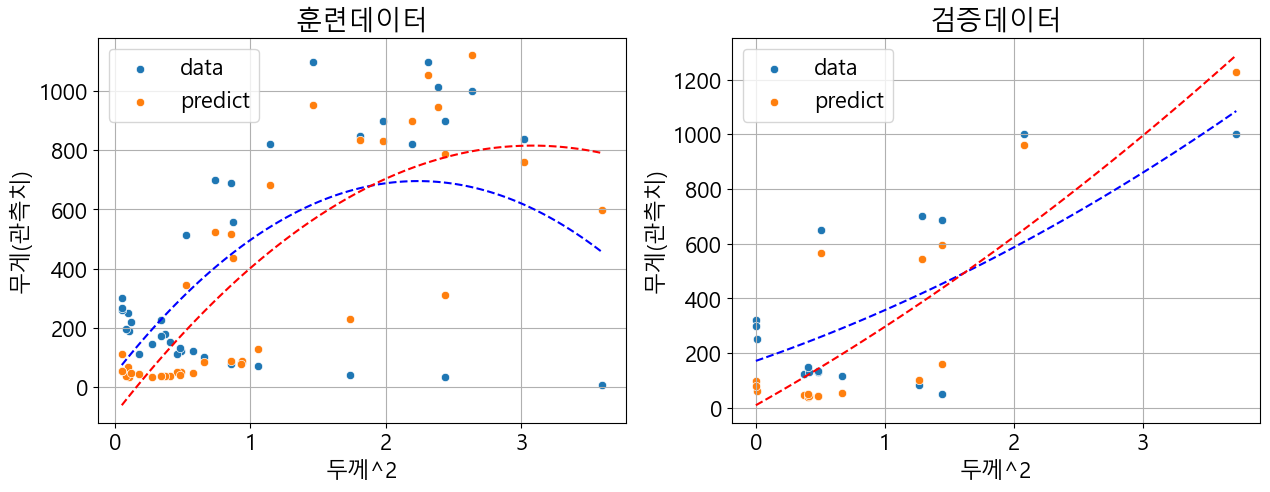

In [46]:
for key in x.columns:
    helper.regplot(train_df[key], train_df['무게(관측치)'], train_df['무게(예측치)'], "훈련데이터",
                   test_df[key], test_df['무게(관측치)'], test_df['무게(예측치)'], "검증데이터",
                   figsize=(15, 5))
